# Stacking Single-Source Heatmaps 

Instead of using an input array composed of a grid made up of multiple sources (with different intensities and positions) to predict the output heatmap array, here we will make a model that can predict the heatmap for a single source using `(intensity,x,y)`  then stack (ie. add) the predictions from multiple individual sources to make a compound prediction for multiple sources.

The first step is to make a model that predicts the heatmap for a single source that works satisfactorally, then we combine multiple predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def generate_single_source_dataset(
    m, n, num_heatmaps=10, 
    min_source_intensity = 0, max_source_intensity = 100,
    log_scale=False, min_element_pct = 0.01):
    """Generates dataset of source matrices (location,intensity of sources) and 
    heatmap matrices (location, intensity due to all sources, obeying inverse-square law)
    PARAMETERS:
        m(int):                 Number of rows in matrix
        n(int):                 Number of columns in matrix
        num_sources(int):       Number of sources to add (random intensity,x,y)
        min_source_intensity(numeric):  Minimum intensity to draw random intensities from
        max_source_intensity(numeric):  Maximum intensity to draw random intensities from
        num_heatmaps(int):      Number of heatmaps to generate
        log_scale(bool):        Whether heatmap intensity should be log scaled
        min_element_pct(float): If log_scale==True, replace intensities below this value with this value (avoids -inf)
    """
    xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    source_vectors = np.zeros((num_heatmaps, 3,1))

    # make a bunch of random sources
    for i in range(num_heatmaps):
        intensity,x,y = create_random_source(max_source_intensity, m, n, min_i=min_source_intensity)
        
        source_vectors[i] = np.array((intensity,x,y)).reshape(3,1)
        intensity_dist = np.zeros((m, n))
        
        
        # add intensity from each source using inverse-square law
        distances = np.sqrt((xx - x)**2 + (yy - y)**2) # distance from ever point in grid to source
        distances = np.where(distances==0, 1, distances) # replace distances less than 1 with 1 to avoid div/0
        intensity_dist += intensity / distances**2                                                               

        if log_scale==True:
            heatmap_matrices[i] = log_scale_matrix(intensity_dist, min_element_pct)
        else:
            heatmap_matrices[i] = intensity_dist    
    return source_vectors, heatmap_matrices


def create_random_source(max_i=100, max_y=10, max_x=10, min_i =0):
    """ Creates a tuple that represents a source with random x,y,intensity"""
    intensity = round(min_i + np.random.random()*(max_i-min_i),2)
    x = int(np.random.random()  * max_x)
    y = int(np.random.random() * max_y)
    return intensity, x ,y


def log_scale_matrix(matrix, min_element_pct):
    """Transforms matrix values by taking log of each element. 
    Replaces small values to avoid -inf when taking log
    """
    min_element = matrix.max()*min_element_pct
    return np.log(np.where(matrix<min_element, min_element, matrix)) # replace low intensities to avoid log(intensity)=-inf)


def plot_heatmap(data, title = "", height = 3, cmap="viridis", norm="linear"):  
    """plots a heatmap with colorbar"""
    plt.figure(figsize=(height,height))
    img = plt.imshow(data, cmap=cmap, interpolation='nearest', norm=norm)
    plt.gca().invert_yaxis()
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    return

# Make dataset of single sources

In [129]:
heatmap_w, heatmap_h = 32, 32
n_sources=1
num_heatmaps = 10000
min_intensity = 10
max_intensity = 100
# log_scale=True
log_scale=False
min_element_pct = 0.02 # controls size of "glow" around source when log_scale=True

Xs, Ys = generate_single_source_dataset(heatmap_h, heatmap_w, num_heatmaps, 
                                     min_intensity, max_intensity,
                                     log_scale, min_element_pct)
Xs.shape

(10000, 3, 1)

intesity=96.49, x=21.0, y=20.0


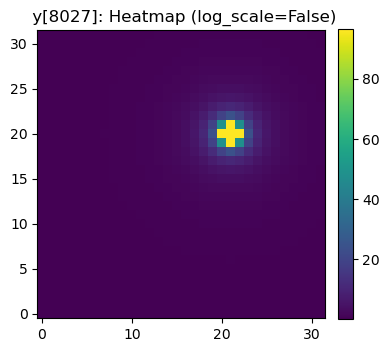

In [130]:
# Look at a sample (re-run to get another sample)
idx = np.random.randint(Xs.shape[0])
i,x,y = Xs[idx].reshape(3,)
print(f"intesity={i}, x={x}, y={y}")
plot_heatmap(Ys[idx], height = 4, title=f" y[{idx}]: Heatmap (log_scale={log_scale})")

# Make model to predict single source heatmap

In [131]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0., alpha=0.3):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
        else:
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [132]:
Xs_reshaped = Xs.reshape((num_heatmaps, 3))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 3) (8000, 1024)
(2000, 3) (2000, 1024)


In [133]:
n_epochs = 100
hidden_layers = [1024, 1024, 1024,1024]
batch_size = 32
alpha = 0.2

# build the model
model = build_model_leaky(X_train.shape[1], hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    verbose=1)

Epoch 1/100
250/250 [==============================] - 2s 8ms/step - loss: 19.9582 - mean_squared_error: 19.9582 - val_loss: 21.5416 - val_mean_squared_error: 21.5416
Epoch 2/100
250/250 [==============================] - 2s 9ms/step - loss: 17.7919 - mean_squared_error: 17.7919 - val_loss: 16.6915 - val_mean_squared_error: 16.6915
Epoch 3/100
250/250 [==============================] - 2s 8ms/step - loss: 16.7494 - mean_squared_error: 16.7494 - val_loss: 15.2876 - val_mean_squared_error: 15.2876
Epoch 4/100
250/250 [==============================] - 2s 8ms/step - loss: 16.1171 - mean_squared_error: 16.1171 - val_loss: 18.7721 - val_mean_squared_error: 18.7721
Epoch 5/100
250/250 [==============================] - 2s 8ms/step - loss: 15.5094 - mean_squared_error: 15.5094 - val_loss: 13.8974 - val_mean_squared_error: 13.8974
Epoch 6/100
250/250 [==============================] - 2s 8ms/step - loss: 15.0860 - mean_squared_error: 15.0860 - val_loss: 15.5932 - val_mean_squared_error: 15.593

In [134]:
def plot_compare_heatmaps(actual, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    # Plot actual heatmap
    im1 = axes[0].imshow(actual, cmap='plasma', origin='lower')
    axes[0].set_title("Target heatmap")
    fig.colorbar(im1, ax=axes[0],fraction=0.046, pad=0.04) 
    # im1.set_clim(vmin=actual.min(), vmax=actual.max())

    # Plot predicted heatmap
    im2 = axes[1].imshow(predicted, cmap='plasma', origin='lower')
    axes[1].set_title("Predicted heatmap")
    fig.colorbar(im2, ax=axes[1],fraction=0.046, pad=0.04) 
    # im2.set_clim(vmin=actual.min(), vmax=actual.max())

    plt.tight_layout()
    plt.show()

In [135]:
preds = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


source:    (x,y)=(10, 31), intesity=34.09
predicted: (x,y)=(9, 31), intesity=32.036895751953125


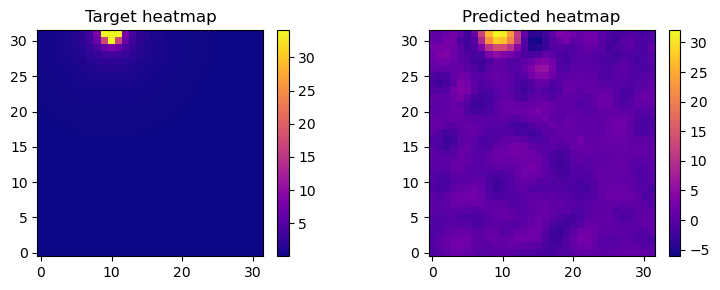

In [136]:
# pick random sample to examine
idx = np.random.randint(y_test.shape[0])
i,x,y = X_test[idx].reshape(3,)
if log_scale==True:
    i = np.log(i)
print(f"source:    (x,y)={round(x),round(y)}, intesity={i}")

predicted = preds[idx].reshape((heatmap_w,heatmap_h))
y,x = np.unravel_index(predicted.argmax(), predicted.shape)
print(f"predicted: (x,y)={(x,y)}, intesity={predicted.max()}")
plot_compare_heatmaps(y_test[idx].reshape((heatmap_w, heatmap_h)), predicted)

**Notes:** Well this kinda works in that the position of the source fairly accurate, but the intensity is not.

# Stack multiple single-source predictions
This allows us to make a prediction for multiple sources. Each source is an X, each prediction is a y

log_scale=False
2 sources


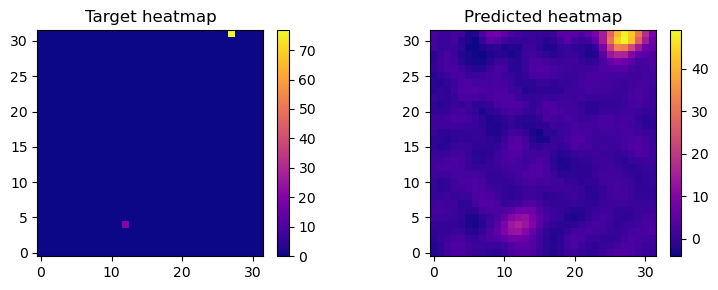

3 sources


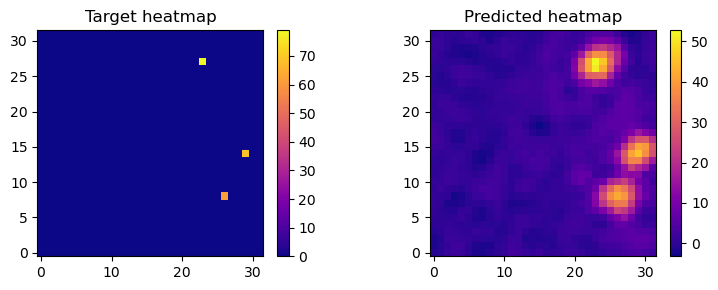

4 sources


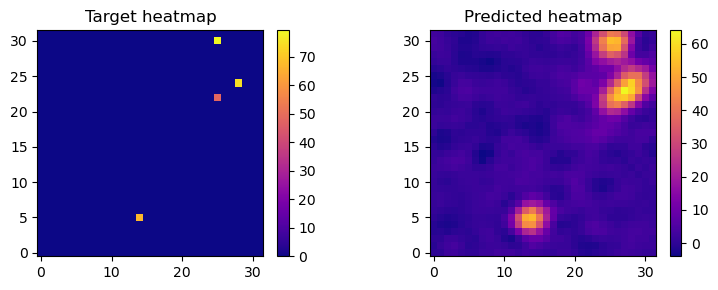

5 sources


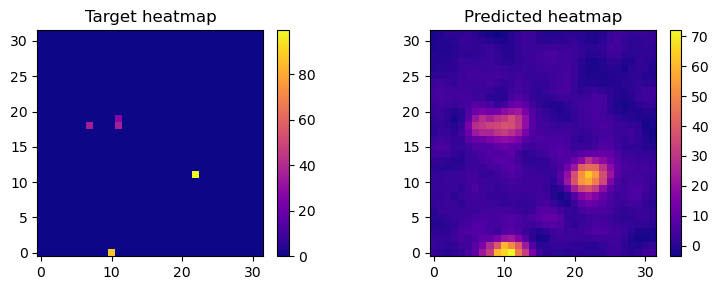

6 sources


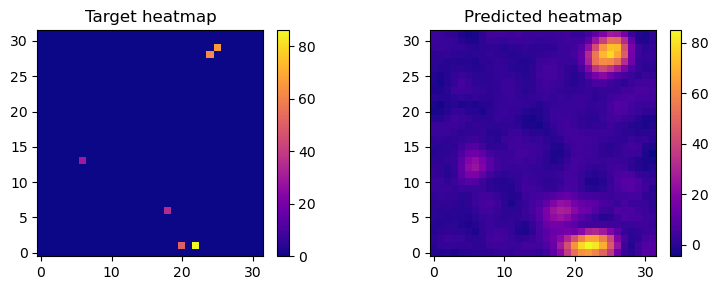

7 sources


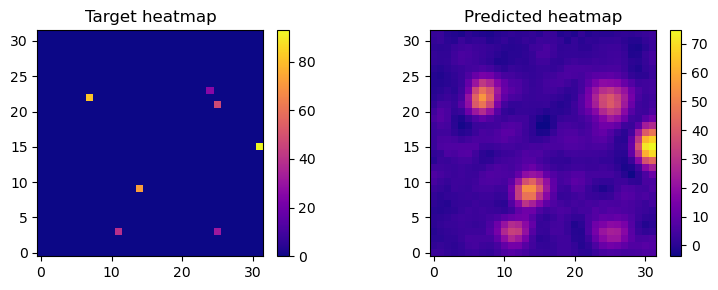

8 sources


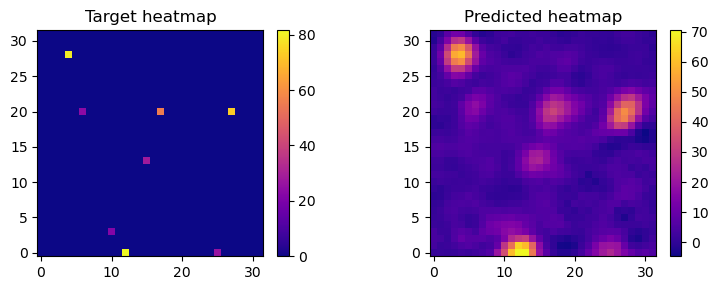

9 sources


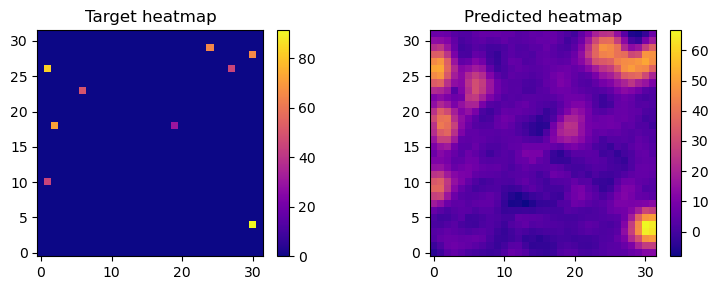

In [141]:
max_intensity = 100
min_intensity = 20 # 
n_sources = 4
print(f"log_scale={log_scale}")


for n_sources in np.arange(2,10,1):
    print(f"{n_sources} sources")
    # Make array of sources 
    sources = np.zeros((n_sources,3))
    for i in range(n_sources):
        intensity,x,y = create_random_source(max_intensity, heatmap_w, heatmap_h, min_i=min_intensity)
        
        if log_scale==True:
            intensity = np.log(intensity)
        sources[i] = np.array((intensity,x,y)).reshape(3)
    
    # create source array for for visualization
    source_array = np.zeros((heatmap_w, heatmap_h))
    for source in sources:
        i,x,y = source
        source_array[int(y),int(x)]+=i
    
    # predict heatmap for every single source
    preds = model.predict(sources, verbose = 0) 

    # add individual predictions
    stacked_heatmap = np.zeros((heatmap_w, heatmap_h))
    for pred in preds:
        stacked_heatmap+=pred.reshape((heatmap_w, heatmap_h))

    plot_compare_heatmaps(source_array, stacked_heatmap)

**Notes:** This also kinda works in that the pattern of sources is reproduced, but the intensity is still not correct and nearby source get merged together.